In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter

### ICO (*International Coffee Organization*) website data preprocessing in Coffee production category

In [2]:
url_list = ["https://www.ico.org/historical/1990%20onwards/Excel/1a%20-%20Total%20production.xlsx",
            "https://www.ico.org/historical/1990%20onwards/Excel/2a%20-%20Exports%20-%20calendar%20year.xlsx",
            "https://www.ico.org/historical/1990%20onwards/Excel/2c%20-%20Re-exports.xlsx",
            "https://www.ico.org/historical/1990%20onwards/Excel/4a%20-%20Inventories.xlsx"]

In [17]:
    df_list = []

    def data_loading(url):
        
        for i in url:
            # Data loadning from url
            df = pd.read_excel(i, header=3)
            # df = df.rename(columns={'Unnamed: 1': 'Coffee type'})
            df_list.append(df)
        
    data_loading(url_list)      

C:\Users\dell\miniconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
df_production = df_list[0]
df_export = df_list[1]
df_re_export = df_list[2]
df_inventorie = df_list[3]

In [22]:
# Function for data preprocessing (cleaning, value change, deduplication, droping rows and values)

def data_production_preprocesing(*args):
    
    global df_production
    
    # Data preprocesing, variable rename
    df_production = df_production.rename(columns={"Unnamed: 1" : "Coffee type", "Crop year" : "Country"})
    df_production["Coffee type"].value_counts()
    df_production["Coffee type"].replace({"(A)" : "Arabica", "(R)" : "Robusta", "(R/A)" : "Robusta/Arabica",
                           "(A/R)" : "Arabica/Robusta", 0 : "Arabica"}, inplace=True)
    df_production.dropna(how='all', inplace=True)
    df_production['Coffee type'].isna()
    df_production.drop(index=[1, 17, 26, 62, 63], axis=0, inplace=True)
    df_production.reset_index(drop=True)
    
    # Rounding numeric values
    df_production_1 = df_production.iloc[:, 2:32]
    df_production_1.reset_index(drop=True)
    df_production_2 = df_production.iloc[:, 0:2]
    df_production_2.reset_index(drop=True)
    
    df_production_1 = df_production_1.apply(lambda x : round(x, 0))
    
    # In order to obtain kg values, data have to be multiplaying by 60 kg coffee bags  
    df_production_1 = df_production_1.apply(lambda x : x * 60)
    
    # Data type change from float to intiger
    df_production_1[[col for col in df_production_1.columns if df_production_1[col].dtypes == float]] = \
    df_production_1[[col for col in df_production_1.columns if df_production_1[col].dtypes == float]].astype(int)
    df_production = pd.concat([df_production_2, df_production_1], axis=1).reset_index(drop=True)
    
    # Total consumption
    df_production['Total_production'] = df_production.iloc[:, 2:33].sum(axis=1)
    
    return df_production

df_production = data_production_preprocesing()

df_production

,Country,Coffee type,1990/91,1991/92,1992/93,1993/94,1994/95,1995/96,1996/97,1997/98,...,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,2017/18,2018/19,2019/20,Total_production
0,Angola,Robusta/Arabica,3000,4740,4680,1980,4620,3720,4260,3840,...,1740,1980,2100,2340,2460,2700,2100,2520,3120,82080
1,Bolivia (Plurinational State of),Arabica,7380,6240,7200,3060,7020,8520,7500,8460,...,7920,6300,7200,6000,5040,4680,5040,4980,4860,207000
2,Brazil,Arabica/Robusta,1637160,1637580,2076180,1690020,1691520,1083600,1751820,1568880,...,2915520,3325080,3281340,3198300,3172260,3407280,3164400,3907860,3492660,75082980
3,Burundi,Arabica/Robusta,29220,40020,37200,23580,39840,26040,24060,15000,...,12240,24360,9780,14880,16140,11760,12120,12240,16320,623640
4,Ecuador,Arabica/Robusta,90240,127440,71100,124140,142560,113280,119580,71460,...,49500,49680,39960,38640,38640,38700,37440,29760,33540,1900380
5,Indonesia,Robusta/Arabica,446460,509580,334140,404580,322080,274380,493260,457260,...,413340,784200,774060,656760,755100,692460,651120,577080,685980,15404880
6,Madagascar,Robusta,58920,55980,67320,26520,38460,47100,50940,37440,...,35100,30000,35040,30060,24840,27180,24240,22740,22980,1045560
7,Malawi,Arabica,6300,7440,8220,3720,5040,5460,2940,3660,...,1560,1380,1680,1500,1260,1200,840,780,960,82260
8,Papua New Guinea,Arabica/Robusta,57780,44820,54000,61140,68340,60120,65340,64440,...,84840,42960,50100,47880,42720,70260,44040,55800,45120,1803120
9,Paraguay,Arabica,7860,4800,3240,4020,1500,1560,1860,2940,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,62220


### Barchart *Total coffee production crop year from 1990 to 2020 year*

C:\Users\dell\AppData\Local\Temp/ipykernel_8256/1468362666.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


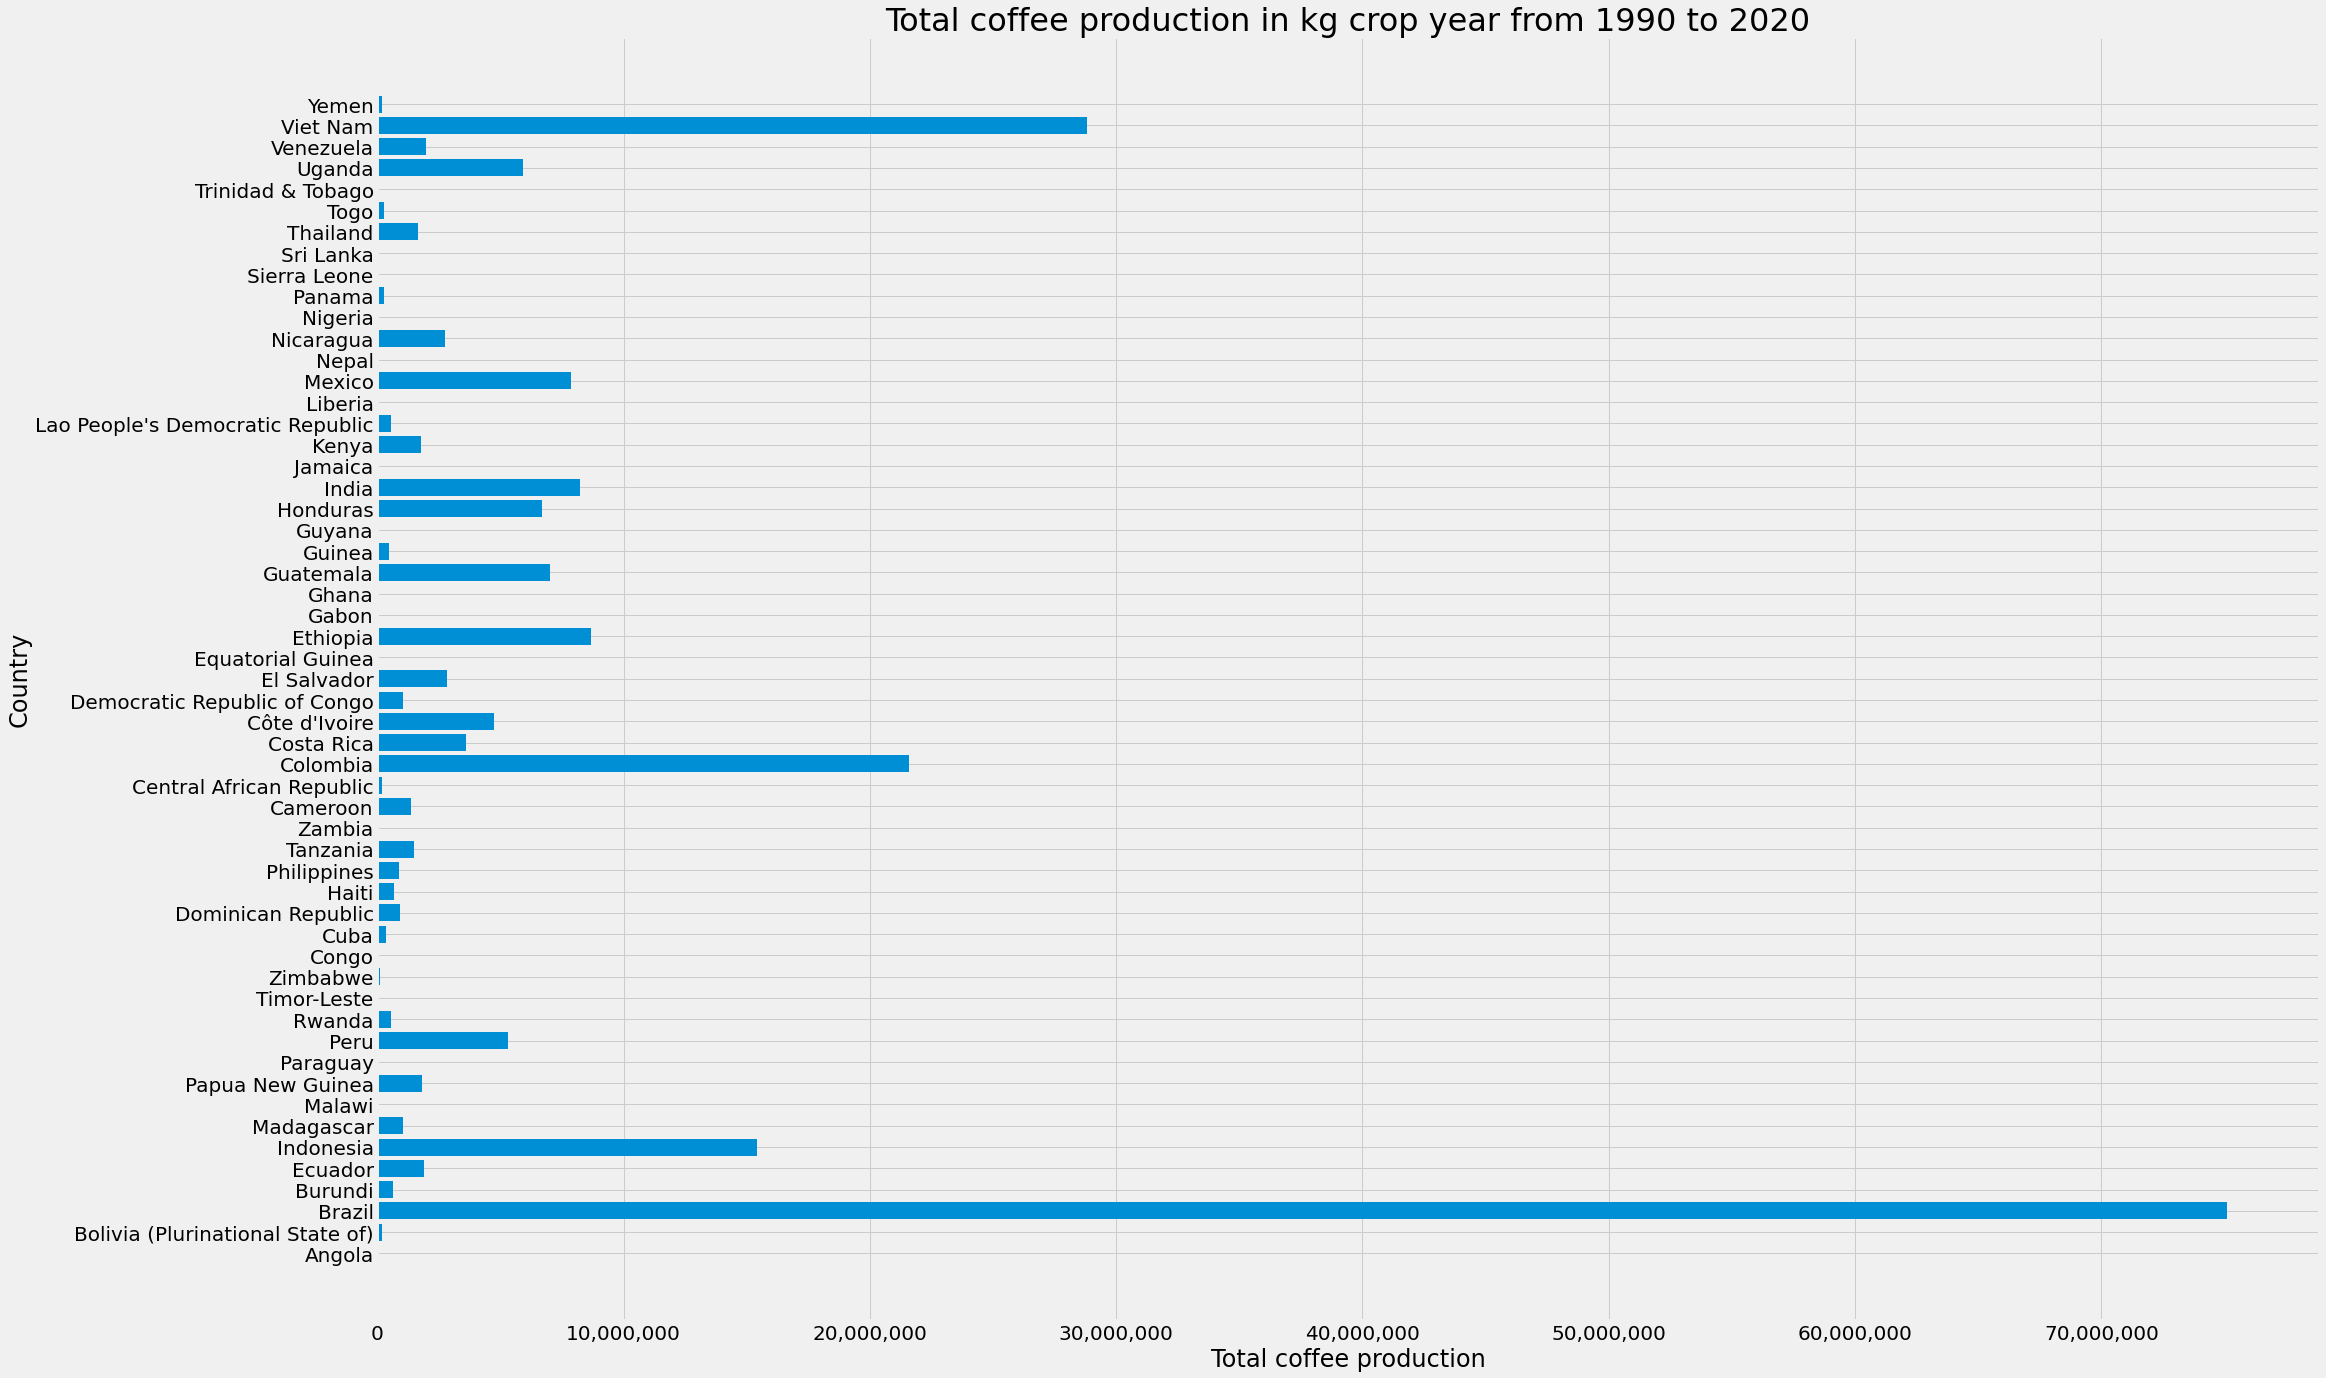

In [24]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(31, 22))

#Horizontal barchart
plt.barh(df_production["Country"], df_production["Total_production"])

# X-axis value size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Label title
plt.xlabel('Total coffee production', fontsize=24) 
plt.ylabel('Country', fontsize=24)

current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#Title label
plt.title("Total coffee production in kg crop year from 1990 to 2020", fontsize=32)

plt.show();

In [29]:
url_domestic_consumption = r"https://www.ico.org/historical/1990%20onwards/Excel/1b%20-%20Domestic%20consumption.xlsx"

In [30]:
def reading_consumption_data(*args):
    
    # Upload data, preliminary cleaning
    df_domestic_consumption = pd.DataFrame()
    df_domestic_consumption = pd.read_excel(url_domestic_consumption, header=3)
    df_domestic_consumption = df_domestic_consumption.rename(columns={'Unnamed: 1': 'Coffee type', 
                                                                      "Crop year" : "Country"})
    
    return df_domestic_consumption

df_domestic_consumption = reading_consumption_data()
df_domestic_consumption

C:\Users\dell\miniconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Country,Coffee type,1990/91,1991/92,1992/93,1993/94,1994/95,1995/96,1996/97,1997/98,...,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,2017/18,2018/19,2019/20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,April group,NaN,10408.000,10707.600,11212.200,11452.743,11506.499,12334.100,13235.500,13804.500,...,23439.42,24345.726,25170.701,25262.529,25658.914,25948.29,26757.4900,27635.990,27900.490,27701.490
2,Angola,(R/A),20.000,30.000,35.000,20.000,25.000,10.000,20.000,40.000,...,30.00,30.000,30.000,30.000,30.000,30.00,30.0000,30.000,30.000,30.000
3,Bolivia (Plurinational State of),(A),25.000,27.000,27.500,28.500,29.500,30.500,31.500,32.500,...,47.50,49.000,50.500,52.000,53.500,55.00,57.0000,58.500,60.000,61.000
4,Brazil,(A/R),8200.000,8500.000,8900.000,9100.000,9300.000,10100.000,11000.000,11500.000,...,19132.00,19720.000,20330.000,20085.000,20333.000,20508.00,21225.0000,21997.000,22200.000,22000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Viet Nam,(R/A),150.000,230.000,250.000,267.000,267.000,281.845,297.516,314.058,...,1583.00,1650.000,1825.000,2000.000,2200.000,2300.00,2400.0000,2500.000,2600.000,2650.000
60,Yemen,(A),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,130.00,130.000,130.000,130.000,125.000,115.00,100.0000,90.000,65.000,64.000
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,Total,NaN,19509.211,20228.097,20951.452,21097.906,21360.166,22602.572,23512.590,24271.040,...,41646.19,43192.482,44652.513,45323.874,46473.695,47349.20,48334.1704,49685.816,50244.654,49981.524


In [31]:
def data_preprocesing(*args):
    
    global df_domestic_consumption
    # Data preprocesing, variable rename
    df_domestic_consumption["Coffee type"].value_counts()
    df_domestic_consumption["Coffee type"].replace({"(A)" : "Arabica", "(R)" : "Robusta", "(R/A)" : "Robusta/Arabica",
                           "(A/R)" : "Arabica/Robusta"}, inplace=True)
    df_domestic_consumption["Coffee type"].value_counts()
    df_domestic_consumption.dropna(how='all', inplace=True)
    df_domestic_consumption['Coffee type'].isna()
    df_domestic_consumption.drop(index=[1, 17, 26, 62, 63], axis=0, inplace=True)
    df_domestic_consumption.reset_index(drop=True)
    
    # Rounding numeric values
    df_domestic_consumption_1 = df_domestic_consumption.iloc[:, 2:32]
    df_domestic_consumption_1.reset_index(drop=True)
    df_domestic_consumption_2 = df_domestic_consumption.iloc[:, 0:2]
    df_domestic_consumption_2.reset_index(drop=True)
    
    # In order to obtain kg values, data have to be multiplaying by 60 kg coffee bags
    df_domestic_consumption_1 = df_domestic_consumption_1.apply(lambda x : x * 60)
    
    # Data type change from float to intiger
    df_domestic_consumption_1[[col for col in df_domestic_consumption_1.columns if df_domestic_consumption_1[col].dtypes == float]] = \
    df_domestic_consumption_1[[col for col in df_domestic_consumption_1.columns if df_domestic_consumption_1[col].dtypes == float]].astype(int)
    df_domestic_consumption = pd.concat([df_domestic_consumption_2, df_domestic_consumption_1], axis=1).reset_index(drop=True)
    
    # Total consumption
    df_domestic_consumption['Total_domestic_consumption'] = df_domestic_consumption.iloc[:, 2:33].sum(axis=1)
    
    return df_domestic_consumption

df_domestic_consumption = data_preprocesing()

df_domestic_consumption

,Country,Coffee type,1990/91,1991/92,1992/93,1993/94,1994/95,1995/96,1996/97,1997/98,...,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,2017/18,2018/19,2019/20,Total_domestic_consumption
0,Angola,Robusta/Arabica,1200,1800,2100,1200,1500,600,1200,2400,...,1800,1800,1800,1800,1800,1800,1800,1800,1800,46500
1,Bolivia (Plurinational State of),Arabica,1500,1620,1650,1710,1770,1830,1890,1950,...,2940,3030,3120,3210,3300,3420,3510,3600,3660,75180
2,Brazil,Arabica/Robusta,492000,510000,534000,546000,558000,606000,660000,690000,...,1183200,1219800,1205100,1219980,1230480,1273500,1319820,1332000,1320000,27824700
3,Burundi,Arabica/Robusta,120,96,102,114,120,120,120,120,...,120,120,120,120,120,120,120,120,120,3409
4,Ecuador,Arabica/Robusta,21000,21000,21000,21000,21000,21000,18000,18000,...,9000,9000,9300,9300,9300,9300,9300,9300,8940,381540
5,Indonesia,Robusta/Arabica,74520,76800,79140,81540,84000,86580,89160,91920,...,220020,234000,255000,265020,273000,279000,285000,288000,288360,4920480
6,Madagascar,Robusta,21000,18000,21000,21600,9999,10020,10020,10020,...,27000,25800,24600,23400,22200,21600,21900,22500,22500,588705
7,Malawi,Arabica,120,120,120,120,120,120,120,120,...,60,60,60,60,60,60,60,60,60,2340
8,Papua New Guinea,Arabica/Robusta,180,180,180,120,120,120,120,120,...,74,102,122,115,108,120,120,120,120,3606
9,Paraguay,Arabica,900,900,900,1200,1200,1200,1200,1200,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,35100


C:\Users\dell\AppData\Local\Temp/ipykernel_3456/3824569618.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


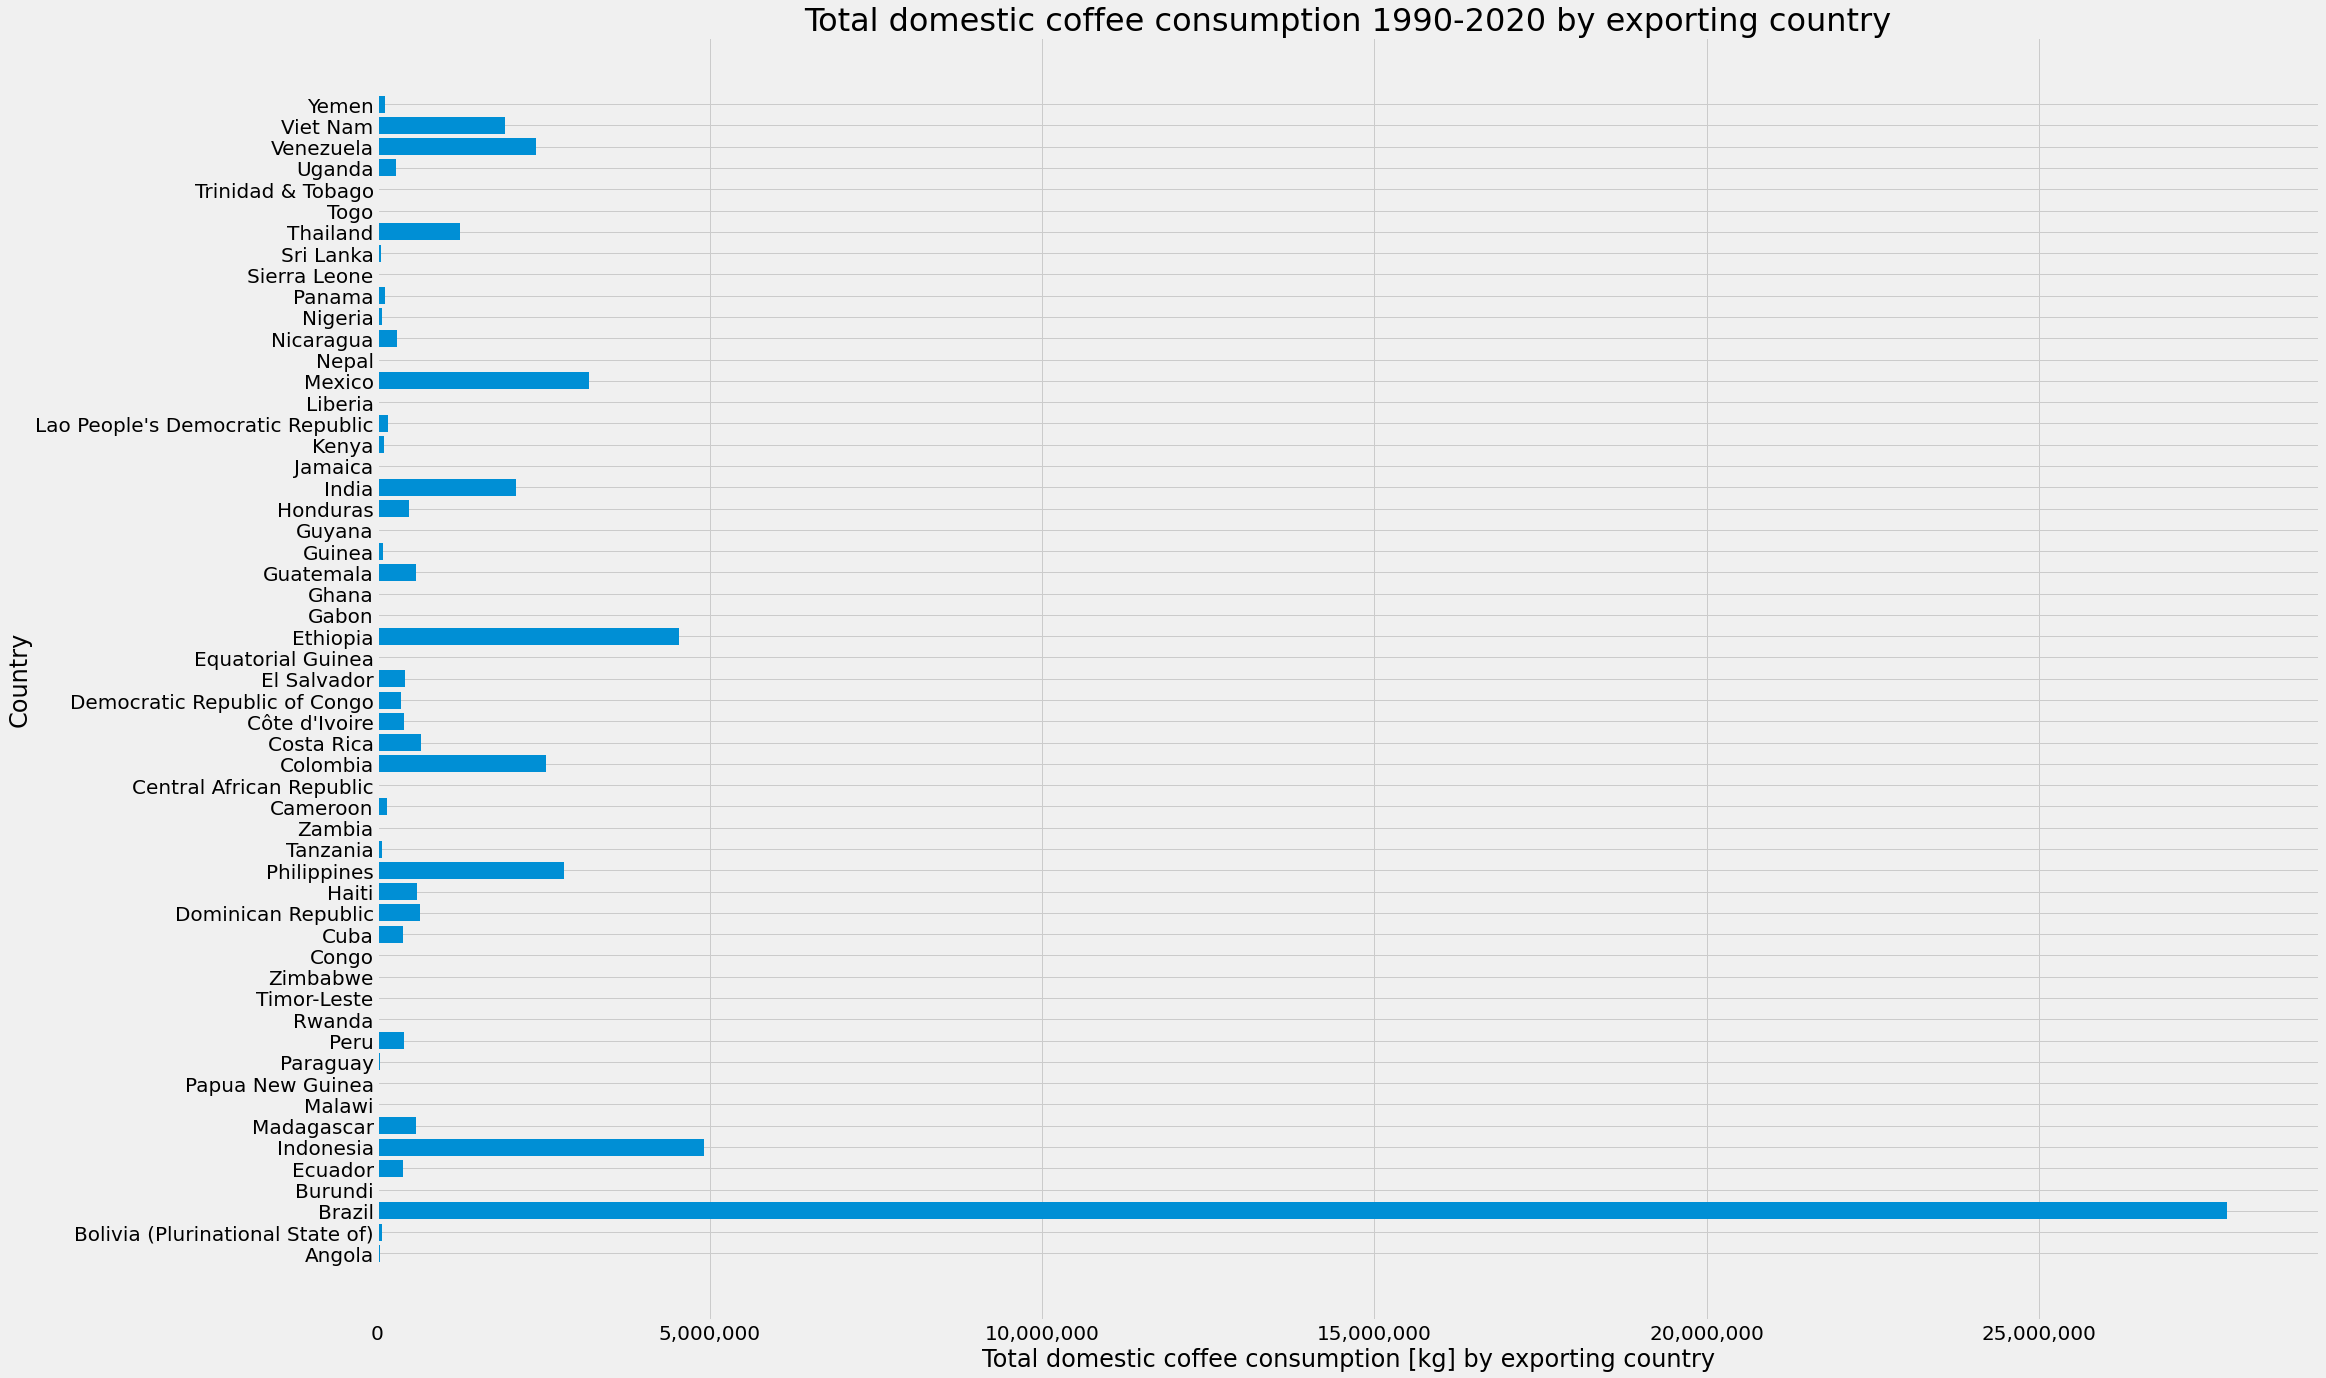

In [32]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(31, 22))

#Horizontal barchart
plt.barh(df_domestic_consumption["Country"], df_domestic_consumption["Total_domestic_consumption"])

# X-axis value size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Label title
plt.xlabel('Total domestic coffee consumption [kg] by exporting country', fontsize=24) 
plt.ylabel('Country', fontsize=24)

current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#Title label
plt.title("Total domestic coffee consumption 1990-2020 by exporting country", fontsize=32)

plt.show();

### Exporters, importers and re-exporters coffee from 1990 to 2019 year

##### Coffee exporters

In [33]:
url_export_data = r"https://www.ico.org/historical/1990%20onwards/Excel/2a%20-%20Exports%20-%20calendar%20year.xlsx"

def reading_export_data(url_adress):
    
    # Upload data, preliminary transforming
    df_export = pd.DataFrame()
    df_export = pd.read_excel(url_adress, header=3)
    df_export = df_export.rename(columns={"Calendar years" : "Country"})
    
    return df_export

df_export = reading_export_data(url_export_data)

df_export

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Angola,84.350000,70.501000,80.250000,38.878000,8.302000,40.559000,51.831000,50.494000,53.929000,...,4.370000,7.575000,8.375000,5.520000,9.375000,10.515000,10.945000,9.055000,9.323397,23.357178
1,Bolivia (Plurinational State of),156.442000,73.523000,96.204000,47.319000,84.321000,93.958000,123.445000,110.955000,97.039000,...,78.268006,74.308883,62.675780,54.850533,61.751267,30.280158,22.456342,26.119992,22.459634,20.341955
2,Brazil,16935.787600,21182.761402,18790.719202,17837.747999,17273.147600,14468.432201,15250.609002,16801.260005,18144.388334,...,33166.641590,33806.009328,28549.425891,31650.562945,37335.172825,37562.846747,34269.150253,30924.567849,35637.358589,40697.863709
3,Burundi,584.773000,687.851000,645.858000,417.609000,507.803000,528.202000,224.076000,528.764000,373.841000,...,307.118958,217.845799,392.006917,194.715883,252.178000,230.188550,204.270831,168.876264,201.725236,292.887291
4,Cameroon,2611.259000,1752.179000,1645.851000,704.530000,545.889000,407.269000,563.549000,1368.030000,745.718000,...,793.845667,490.283067,621.812800,271.949217,375.033867,390.142717,281.128967,245.017117,287.415250,249.902400
5,Central African Republic,196.698000,140.950000,99.975000,137.197000,136.676000,231.542000,98.328000,202.778000,102.320000,...,95.194000,77.943000,77.692000,1.000000,75.027000,43.214000,80.018000,18.112667,38.528000,19.273333
6,Colombia,13943.870000,12599.184998,16564.370001,13568.362004,11768.089000,9814.197000,10588.430998,10918.863002,11259.928999,...,7821.634504,7733.625254,7170.203291,9669.907367,10954.408357,12716.384670,12831.390727,12984.595747,12807.972625,13672.225599
7,Congo,1.680000,0.924000,0.336000,0.504000,1.017000,19.149000,12.634000,2.670000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002037,0.000000,0.000000,0.013083,0.000555
8,Costa Rica,2265.644000,2399.640000,2431.340001,2363.920000,2104.968000,2067.011000,2430.134000,2099.239000,2044.558001,...,1199.982617,1243.059935,1373.667164,1343.951587,1208.918498,1128.190321,1006.928354,987.154641,1207.946296,1039.144361
9,Côte d'Ivoire,4282.866000,3804.734001,4546.368000,4033.107001,2443.993000,2493.946000,2750.602999,4712.982001,4365.288002,...,1912.053443,772.242167,1711.765617,1962.070767,1489.151150,1418.375167,1432.043600,854.620583,1522.457567,2104.257160


In [34]:
def data_export_preprocesing(df):
    
    global df_export
    
    # Data preprocesing, variable rename

    df_export.dropna(how='all', inplace=True)
    df_export.drop(index=[56, 57], axis=0, inplace=True)
    df_export.reset_index(drop=True)

    # Rounding numeric values (values are expressed in thousand 60 kg bags)
    df_export_1 = df_export.iloc[:, 1:]
    df_export_1.reset_index(drop=True, inplace=True)
    df_export_2 = df_export.iloc[:, 0]
    df_export_2.reset_index(drop=True, inplace=True)
    
    # Data are round into whole numbers
    df_export_1 = df_export_1.apply(lambda x : round(x, 0))
    
    # In order to obtain aggregate weight in KG unit, data have to be multiplaying by 60 kg coffee bags  
    df_export_1 = df_export_1.apply(lambda x : x * 60)

    # Data type change from float to intiger
    df_export_1[[col for col in df_export_1.columns if df_export_1[col].dtypes == float]] = \
    df_export_1[[col for col in df_export_1.columns if df_export_1[col].dtypes == float]].astype(int)

    df_export = pd.concat([df_export_2, df_export_1], axis=1).reset_index(drop=True)
    
    # Total import
    df_export['Total_export'] = df_export.iloc[:, 1:].sum(axis=1)
    
    return df_export

df_export = data_export_preprocesing(df_export)

df_export

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total_export
0,Angola,5040,4260,4800,2340,480,2460,3120,3000,3240,...,480,480,360,540,660,660,540,540,1380,43320
1,Bolivia (Plurinational State of),9360,4440,5760,2820,5040,5640,7380,6660,5820,...,4440,3780,3300,3720,1800,1320,1560,1320,1200,137460
2,Brazil,1016160,1270980,1127460,1070280,1036380,868080,915060,1008060,1088640,...,2028360,1712940,1899060,2240100,2253780,2056140,1855500,2138220,2441880,47185920
3,Burundi,35100,41280,38760,25080,30480,31680,13440,31740,22440,...,13080,23520,11700,15120,13800,12240,10140,12120,17580,646200
4,Cameroon,156660,105120,98760,42300,32760,24420,33840,82080,44760,...,29400,37320,16320,22500,23400,16860,14700,17220,15000,1399920
5,Central African Republic,11820,8460,6000,8220,8220,13920,5880,12180,6120,...,4680,4680,60,4500,2580,4800,1080,2340,1140,170700
6,Colombia,836640,755940,993840,814080,706080,588840,635280,655140,675600,...,464040,430200,580200,657240,762960,769860,779100,768480,820320,19878480
7,Congo,120,60,0,60,60,1140,780,180,0,...,0,0,0,0,0,0,0,0,0,2400
8,Costa Rica,135960,144000,145860,141840,126300,124020,145800,125940,122700,...,74580,82440,80640,72540,67680,60420,59220,72480,62340,2991840
9,Côte d'Ivoire,256980,228300,272760,241980,146640,149640,165060,282780,261900,...,46320,102720,117720,89340,85080,85920,51300,91320,126240,4721640


C:\Users\dell\AppData\Local\Temp/ipykernel_3456/4066873699.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


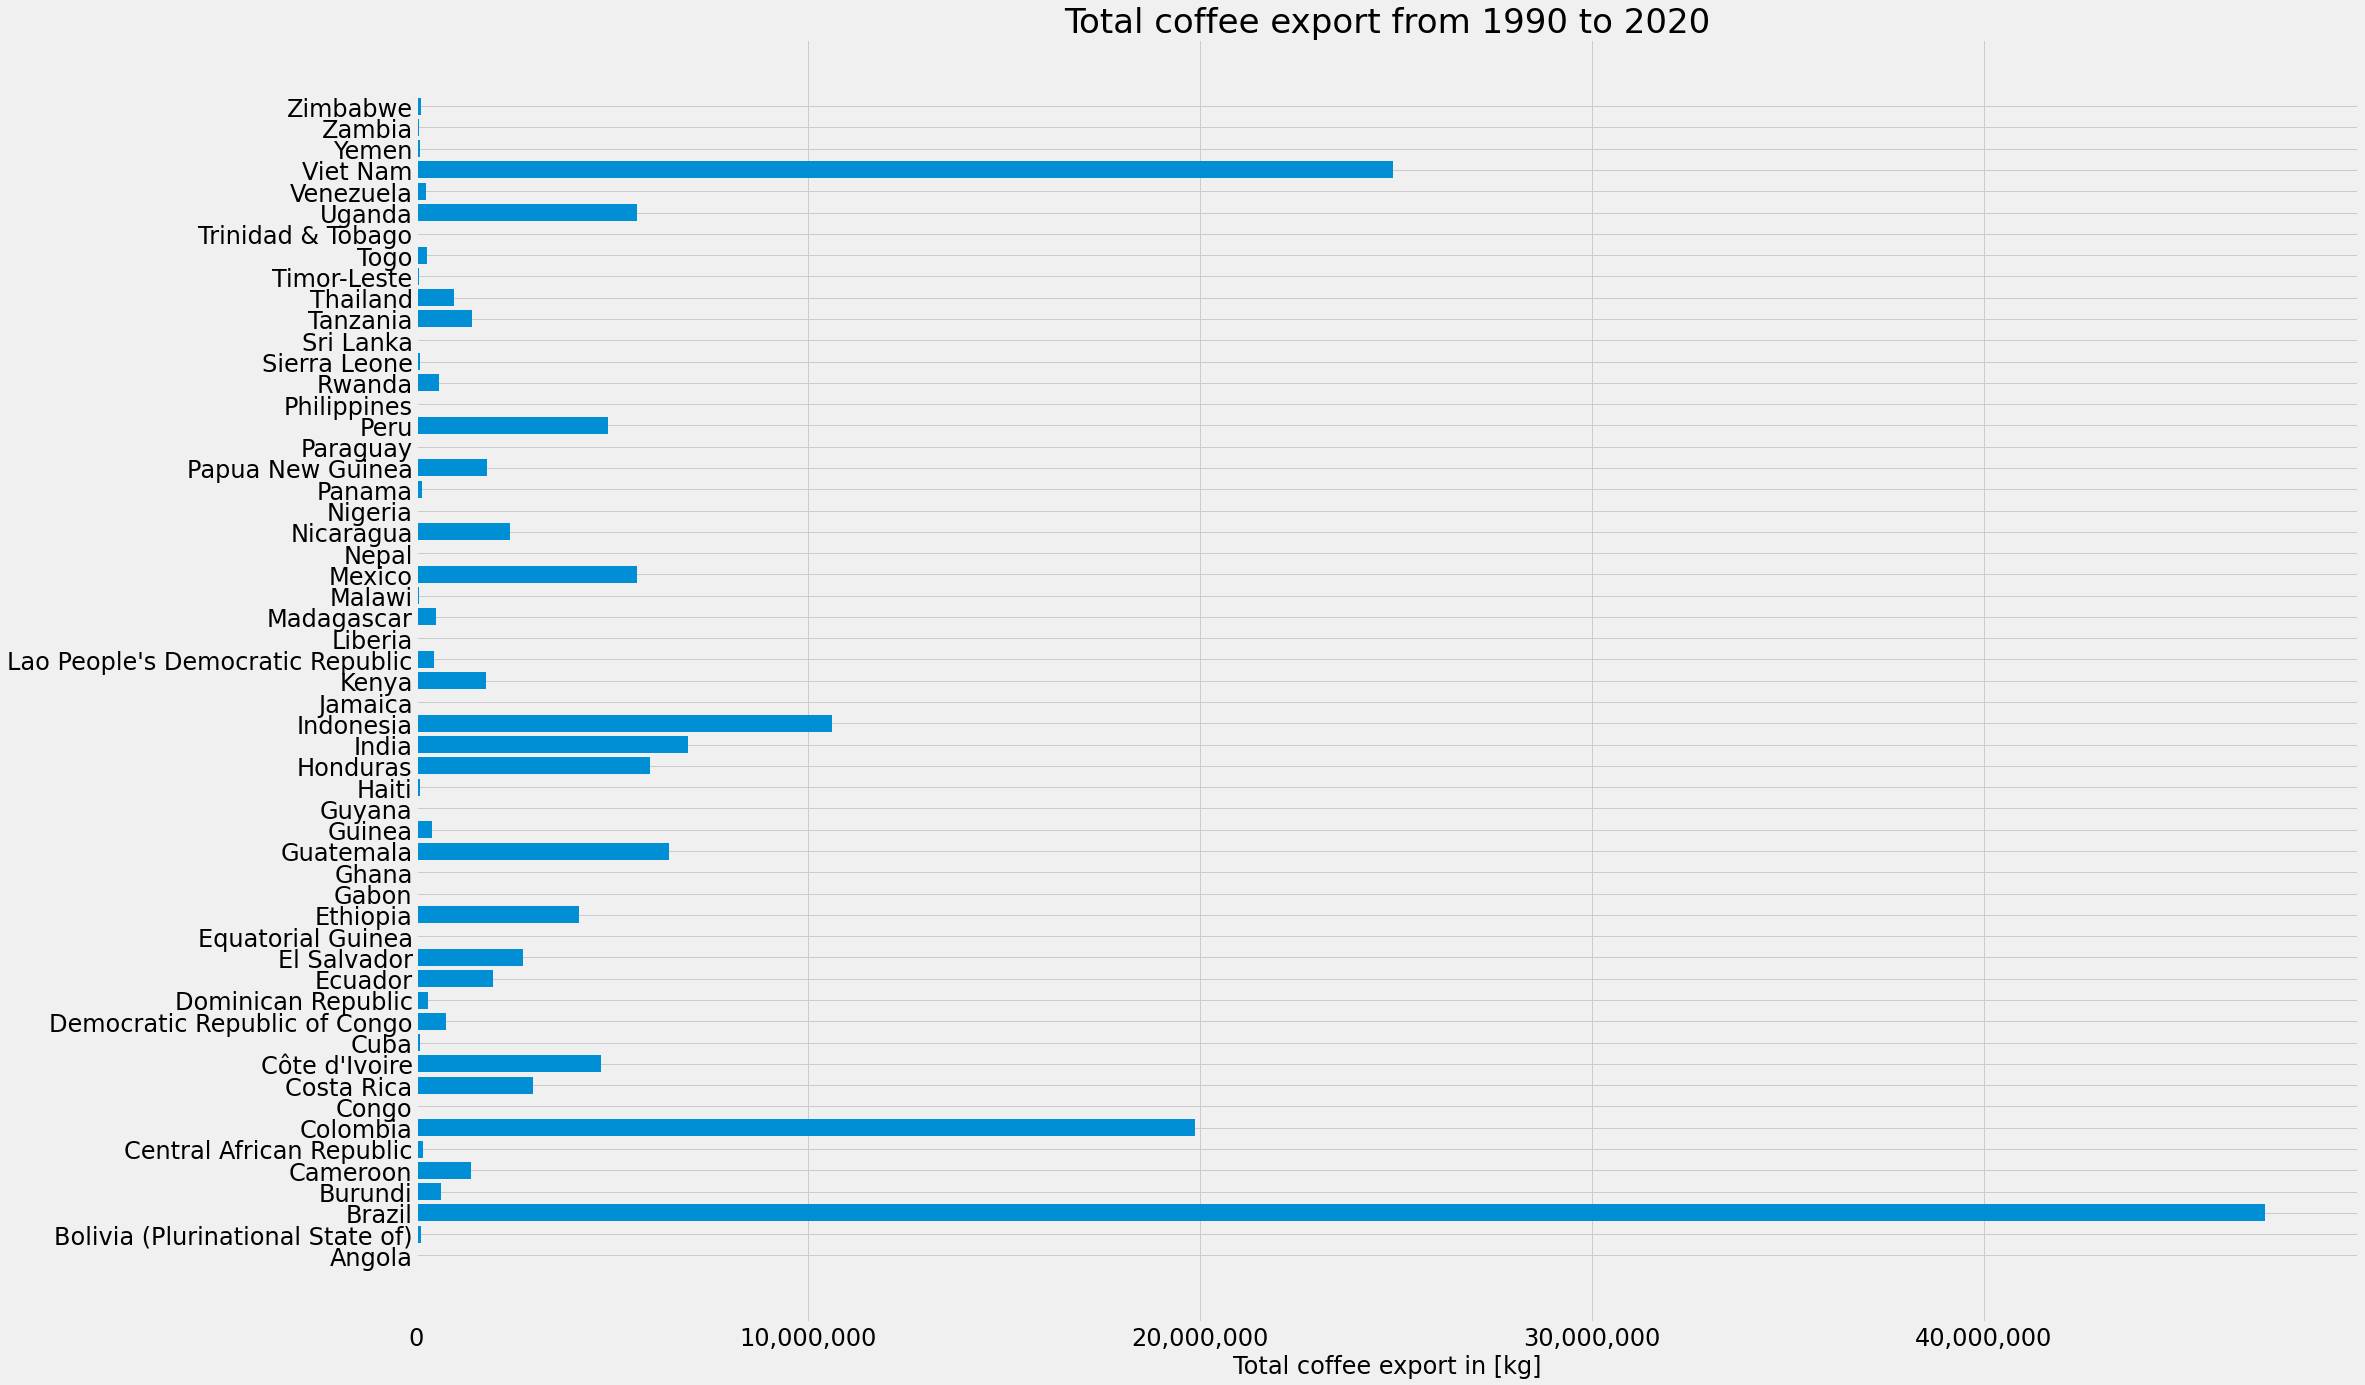

In [35]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(31, 22))

#Horizontal barchart
plt.barh(df_export["Country"], df_export["Total_export"])

# X-axis value size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Label title
plt.xlabel('Total coffee export in [kg]', fontsize=24)

current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#Title label
plt.title("Total coffee export from 1990 to 2020", fontsize=34)

plt.show();

##### Coffee importers

In [36]:
url_import = r"https://www.ico.org/historical/1990%20onwards/Excel/2b%20-%20Imports.xlsx"

def reading_import_data(url_adress):
    
    # Upload data, preliminary transforming
    df_import = pd.DataFrame()
    df_import = pd.read_excel(url_adress, header=3)
    df_import = df_import.rename(columns={"Calendar years" : "Country"})
    
    return df_import

df_import = reading_import_data(url_import)

df_import

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,European Union,42882.776087,41143.872116,44529.994175,45254.467632,45402.131489,43424.386494,46408.406787,47865.245888,48868.782483,...,65522.106177,66052.716803,68136.852018,68030.663301,71893.205688,71995.027768,76402.459294,74221.374859,78151.221303,80057.043941
2,Austria,1879.717004,2058.271005,2206.416005,1836.489002,1417.214004,1231.436001,1210.466006,1294.203405,1293.354106,...,1369.200299,1452.492905,1558.609366,1554.926951,1525.081080,1513.390285,1494.938560,1459.911532,1429.406831,1447.513664
3,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5923.729993,5828.442382,5668.231844,5502.143640,5211.749274,5533.514206,6052.170163,5677.379139,5742.253404,6198.896527
4,Belgium/Luxembourg,2014.954017,1746.225019,1827.851020,2063.260029,2262.473036,2401.498025,2525.823622,2544.379319,3579.677916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Bulgaria,268.182998,200.220001,182.231012,397.443006,462.668007,515.418008,272.159995,294.154003,342.122004,...,528.372082,481.510209,559.825066,609.486668,620.708966,681.756589,779.160013,706.882517,737.243983,784.896715
6,Croatia,NaN,NaN,168.190005,162.774001,193.450002,320.132006,321.835998,385.297004,339.051001,...,393.825469,390.873959,384.490360,412.849422,419.673550,437.201445,478.666658,439.074412,445.513611,466.417527
7,Cyprus,49.853999,53.926000,40.875999,77.412000,51.836001,43.769000,51.501999,41.340999,49.778999,...,76.728448,82.078754,83.877469,93.766183,94.388100,89.304875,93.153307,99.933874,133.179542,133.224874
8,Czechia,659.433000,525.274000,474.731003,514.277005,553.797003,553.196999,525.298002,560.225003,764.839002,...,950.721928,952.366595,1126.622901,1183.882242,1822.690779,2067.838569,1779.351245,1506.967219,1903.158902,1608.921470
9,Denmark,959.105004,982.757004,1061.623004,993.947000,1033.184003,877.159002,1005.999200,949.070500,1013.723201,...,1014.640895,908.869741,913.098994,921.178915,853.423879,840.777636,905.789619,852.193333,867.950523,907.935154


In [37]:
def data_import_preprocesing(df):
    
    global df_import
    
    # Data preprocesing, variable rename

    df_import.dropna(how='all', inplace=True)
    df_import.drop(index=[1, 39, 40], axis=0, inplace=True)
    df_import.reset_index(drop=True)
    
    # Change NaN values to 0 number
    df_import.fillna(0, inplace=True)
    df_import.reset_index(drop=True)

    # Rounding numeric values (values are expressed in thousand 60 kg bags)
    df_import_1 = df_import.iloc[:, 1:]
    df_import_1.reset_index(drop=True, inplace=True)
    df_import_2 = df_import.iloc[:, 0]
    df_import_2.reset_index(drop=True, inplace=True)
    
    # Data are round into whole numbers
    df_import_1 = df_import_1.apply(lambda x : round(x, 0))
    
    # In order to obtain aggregate weight in KG unit, data have to be multiplaying by 60 kg coffee bags  
    df_import_1 = df_import_1.apply(lambda x : x * 60)

    # Data type change from float to intiger
    df_import_1[[col for col in df_import_1.columns if df_import_1[col].dtypes == float]] = \
    df_import_1[[col for col in df_import_1.columns if df_import_1[col].dtypes == float]].astype(int)

    df_import = pd.concat([df_import_2, df_import_1], axis=1).reset_index(drop=True)
    
    # Total import
    df_import['Total_import'] = df_import.iloc[:, 1:].sum(axis=1)
    
    return df_import

df_import = data_import_preprocesing(df_import)

df_import

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total_import
0,Austria,112800,123480,132360,110160,85020,73860,72600,77640,77580,...,87120,93540,93300,91500,90780,89700,87600,85740,86880,2765760
1,Belgium,0,0,0,0,0,0,0,0,0,...,349680,340080,330120,312720,332040,363120,340620,344520,371940,6240540
2,Belgium/Luxembourg,120900,104760,109680,123780,135720,144060,151560,152640,214800,...,0,0,0,0,0,0,0,0,0,1257900
3,Bulgaria,16080,12000,10920,23820,27780,30900,16320,17640,20520,...,28920,33600,36540,37260,40920,46740,42420,44220,47100,830700
4,Croatia,0,0,10080,9780,11580,19200,19320,23100,20340,...,23460,23040,24780,25200,26220,28740,26340,26760,27960,622080
5,Cyprus,3000,3240,2460,4620,3120,2640,3120,2460,3000,...,4920,5040,5640,5640,5340,5580,6000,7980,7980,130380
6,Czechia,39540,31500,28500,30840,33240,33180,31500,33600,45900,...,57120,67620,71040,109380,124080,106740,90420,114180,96540,1816020
7,Denmark,57540,58980,63720,59640,61980,52620,60360,56940,60840,...,54540,54780,55260,51180,50460,54360,51120,52080,54480,1741860
8,Estonia,0,0,960,3060,4980,6420,7020,8460,8100,...,10020,9420,9360,7860,7560,8100,7980,8820,8880,268980
9,Finland,65700,61980,63300,78060,81660,46140,59520,71160,70080,...,77220,74280,76500,72780,79260,83340,81600,77100,90900,2151840


C:\Users\dell\AppData\Local\Temp/ipykernel_3456/1720035948.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


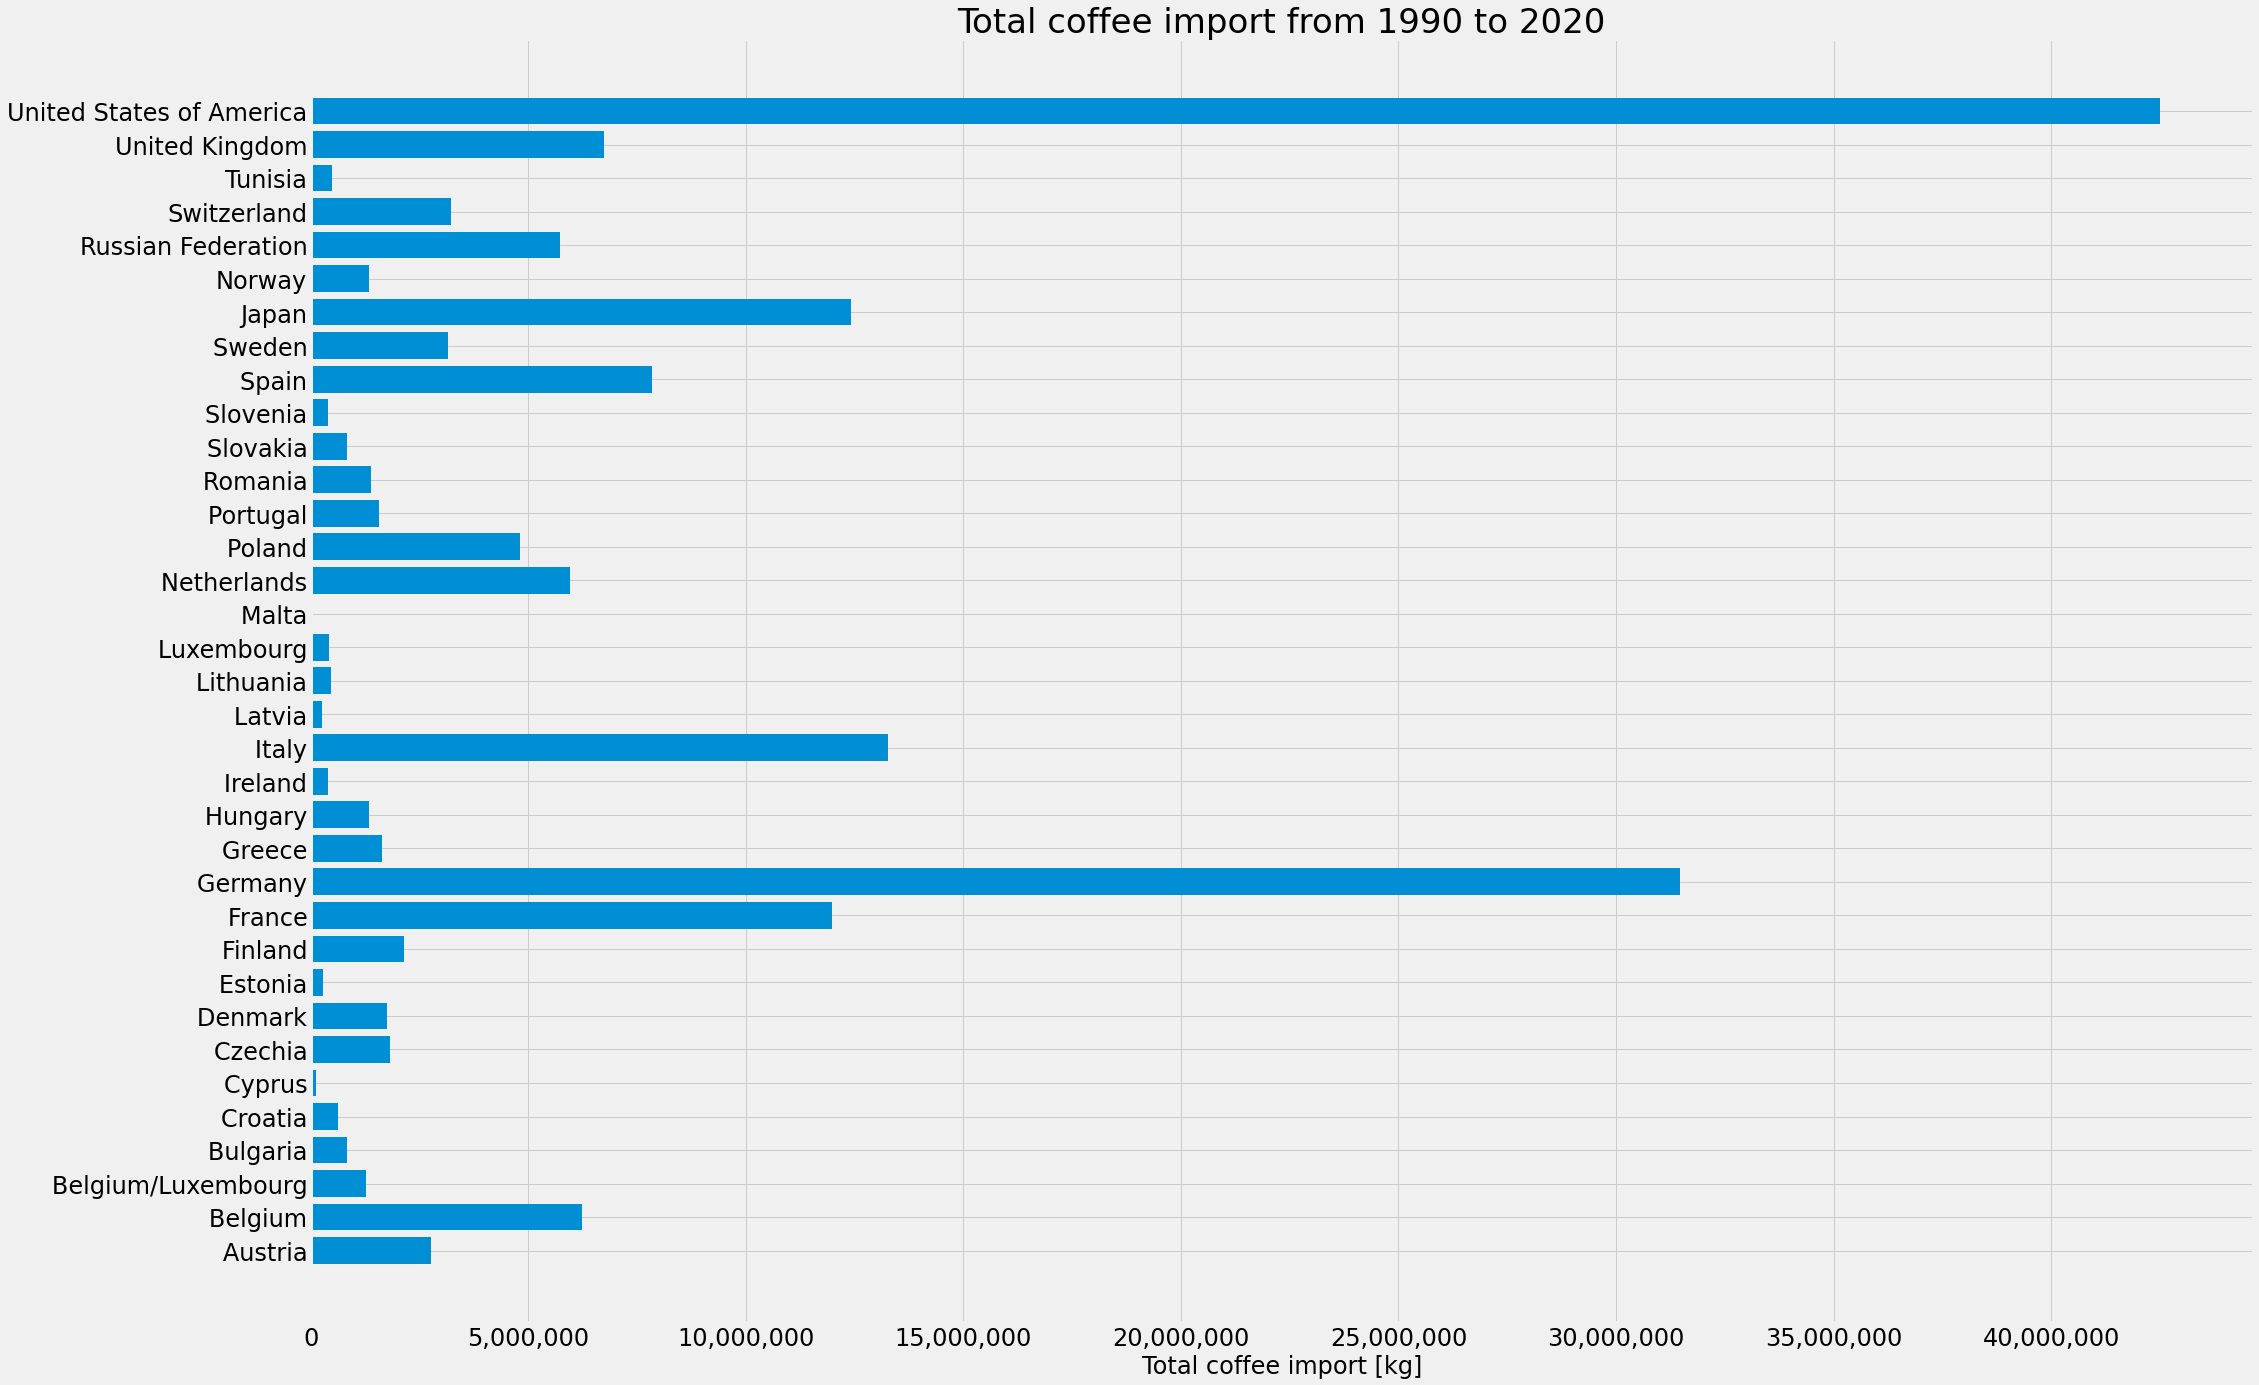

In [38]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(31, 22))

#Horizontal barchart
plt.barh(df_import["Country"], df_import["Total_import"])

# X-axis value size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Label title
plt.xlabel('Total coffee import [kg]', fontsize=24)

current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#Title label
plt.title("Total coffee import from 1990 to 2020", fontsize=34)

plt.show();

##### Coffee re-exporters

In [39]:
url_re_export = r"https://www.ico.org/historical/1990%20onwards/Excel/2c%20-%20Re-exports.xlsx"

def reading_re_export_data(url_adress):
    
    # Upload data, preliminary transforming
    df_re_export = pd.DataFrame()
    df_re_export = pd.read_excel(url_adress, header=3)
    df_re_export = df_re_export.rename(columns={"Calendar years" : "Country"})
    
    return df_re_export

df_re_export = reading_re_export_data(url_re_export)

df_re_export

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,European Union,7267.770128,8085.310173,8554.469193,8488.933823,9200.844923,8800.969466,9563.717875,10543.105455,11798.895307,...,27736.914477,28487.183839,29633.579281,29224.758578,31819.987741,33362.979599,35023.177113,35568.918485,36883.193547,38889.768539
2,Austria,414.593018,756.185035,960.082041,535.488020,380.995008,228.666006,162.678005,222.123808,209.615909,...,463.345970,365.147262,303.589908,310.870847,386.371358,377.551736,307.691478,308.293141,257.413549,274.161979
3,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5053.064814,4893.973633,4753.595285,4256.978879,3952.812466,4459.903535,4550.045360,4377.324264,4377.326748,5013.520188
4,Belgium/Luxembourg,890.844034,1038.068039,1131.478041,1273.823045,1304.258046,1328.483041,1487.186551,1658.115555,2270.271439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Bulgaria,166.400000,183.459000,7.353000,70.488000,109.904001,122.010001,25.685000,19.236000,17.962000,...,133.014090,121.990458,183.883815,190.879821,244.472722,275.499488,326.814054,291.870737,311.524516,361.830065
6,Croatia,NaN,NaN,33.645001,30.884001,29.588001,31.651001,17.367000,23.901001,19.321001,...,23.986876,23.720815,24.126241,26.286796,51.213558,62.553903,99.081481,77.968438,85.576221,85.911755
7,Cyprus,16.283000,7.229000,3.572000,1.896000,1.467000,1.091000,0.761000,0.845000,0.573000,...,2.137800,0.071229,0.973149,1.684554,8.408183,2.577417,3.672933,1.696513,1.214950,23.260300
8,Czechia,NaN,NaN,2.574998,65.882001,45.073003,41.743002,50.306000,75.645004,241.431005,...,480.990250,379.908125,441.396615,546.456926,824.506985,1359.471411,973.344665,702.794108,745.564434,766.220101
9,Denmark,93.966004,74.215003,102.788005,103.391003,124.701001,119.362004,110.985203,140.613306,160.063108,...,208.152144,146.611112,113.274668,98.999117,105.395584,109.377010,152.456804,119.673974,128.456195,129.792538


In [40]:
def data_re_export_preprocesing(df):
    
    global df_re_export
    
    # Data preprocesing, variable rename

    df_re_export.dropna(how='all', inplace=True)
    df_re_export.drop(index=[1, 39, 40], axis=0, inplace=True)
    df_re_export.reset_index(drop=True)
    
    # Change NaN values to 0 number
    df_re_export.fillna(0, inplace=True)
    df_re_export.reset_index(drop=True)

    # Rounding numeric values (values are expressed in thousand 60 kg bags)
    df_re_export_1 = df_re_export.iloc[:, 1:]
    df_re_export_1.reset_index(drop=True, inplace=True)
    df_re_export_2 = df_re_export.iloc[:, 0]
    df_re_export_2.reset_index(drop=True, inplace=True)
    
    # Data are round into whole numbers
    df_re_export_1 = df_re_export_1.apply(lambda x : round(x, 0))
    
    # In order to obtain aggregate weight in KG unit, data have to be multiplaying by 60 kg coffee bags  
    df_re_export_1 = df_re_export_1.apply(lambda x : x * 60)

    # Data type change from float to intiger
    df_re_export_1[[col for col in df_re_export_1.columns if df_re_export_1[col].dtypes == float]] = \
    df_re_export_1[[col for col in df_re_export_1.columns if df_re_export_1[col].dtypes == float]].astype(int)

    df_re_export = pd.concat([df_re_export_2, df_re_export_1], axis=1).reset_index(drop=True)
    
    # Total import
    df_re_export['Total_re_export'] = df_re_export.iloc[:, 1:].sum(axis=1)
    
    return df_re_export

df_re_export = data_re_export_preprocesing(df_re_export)

df_re_export

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total_re_export
0,Austria,24900,45360,57600,32100,22860,13740,9780,13320,12600,...,21900,18240,18660,23160,22680,18480,18480,15420,16440,869220
1,Belgium,0,0,0,0,0,0,0,0,0,...,293640,285240,255420,237180,267600,273000,262620,262620,300840,4779780
2,Belgium/Luxembourg,53460,62280,67860,76440,78240,79680,89220,99480,136200,...,0,0,0,0,0,0,0,0,0,742860
3,Bulgaria,9960,10980,420,4200,6600,7320,1560,1140,1080,...,7320,11040,11460,14640,16500,19620,17520,18720,21720,205620
4,Croatia,0,0,2040,1860,1800,1920,1020,1440,1140,...,1440,1440,1560,3060,3780,5940,4680,5160,5160,57900
5,Cyprus,960,420,240,120,60,60,60,60,60,...,0,60,120,480,180,240,120,60,1380,7980
6,Czechia,0,0,180,3960,2700,2520,3000,4560,14460,...,22800,26460,32760,49500,81540,58380,42180,44760,45960,674640
7,Denmark,5640,4440,6180,6180,7500,7140,6660,8460,9600,...,8820,6780,5940,6300,6540,9120,7200,7680,7800,289800
8,Estonia,0,0,180,420,1200,1500,1980,2520,2700,...,6000,3180,2160,840,420,780,1500,1260,1500,93240
9,Finland,1140,1260,2100,11880,13020,5820,10320,12300,11160,...,11640,9360,10860,10980,12660,14520,17880,10740,10080,284400


C:\Users\dell\AppData\Local\Temp/ipykernel_3456/299209702.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


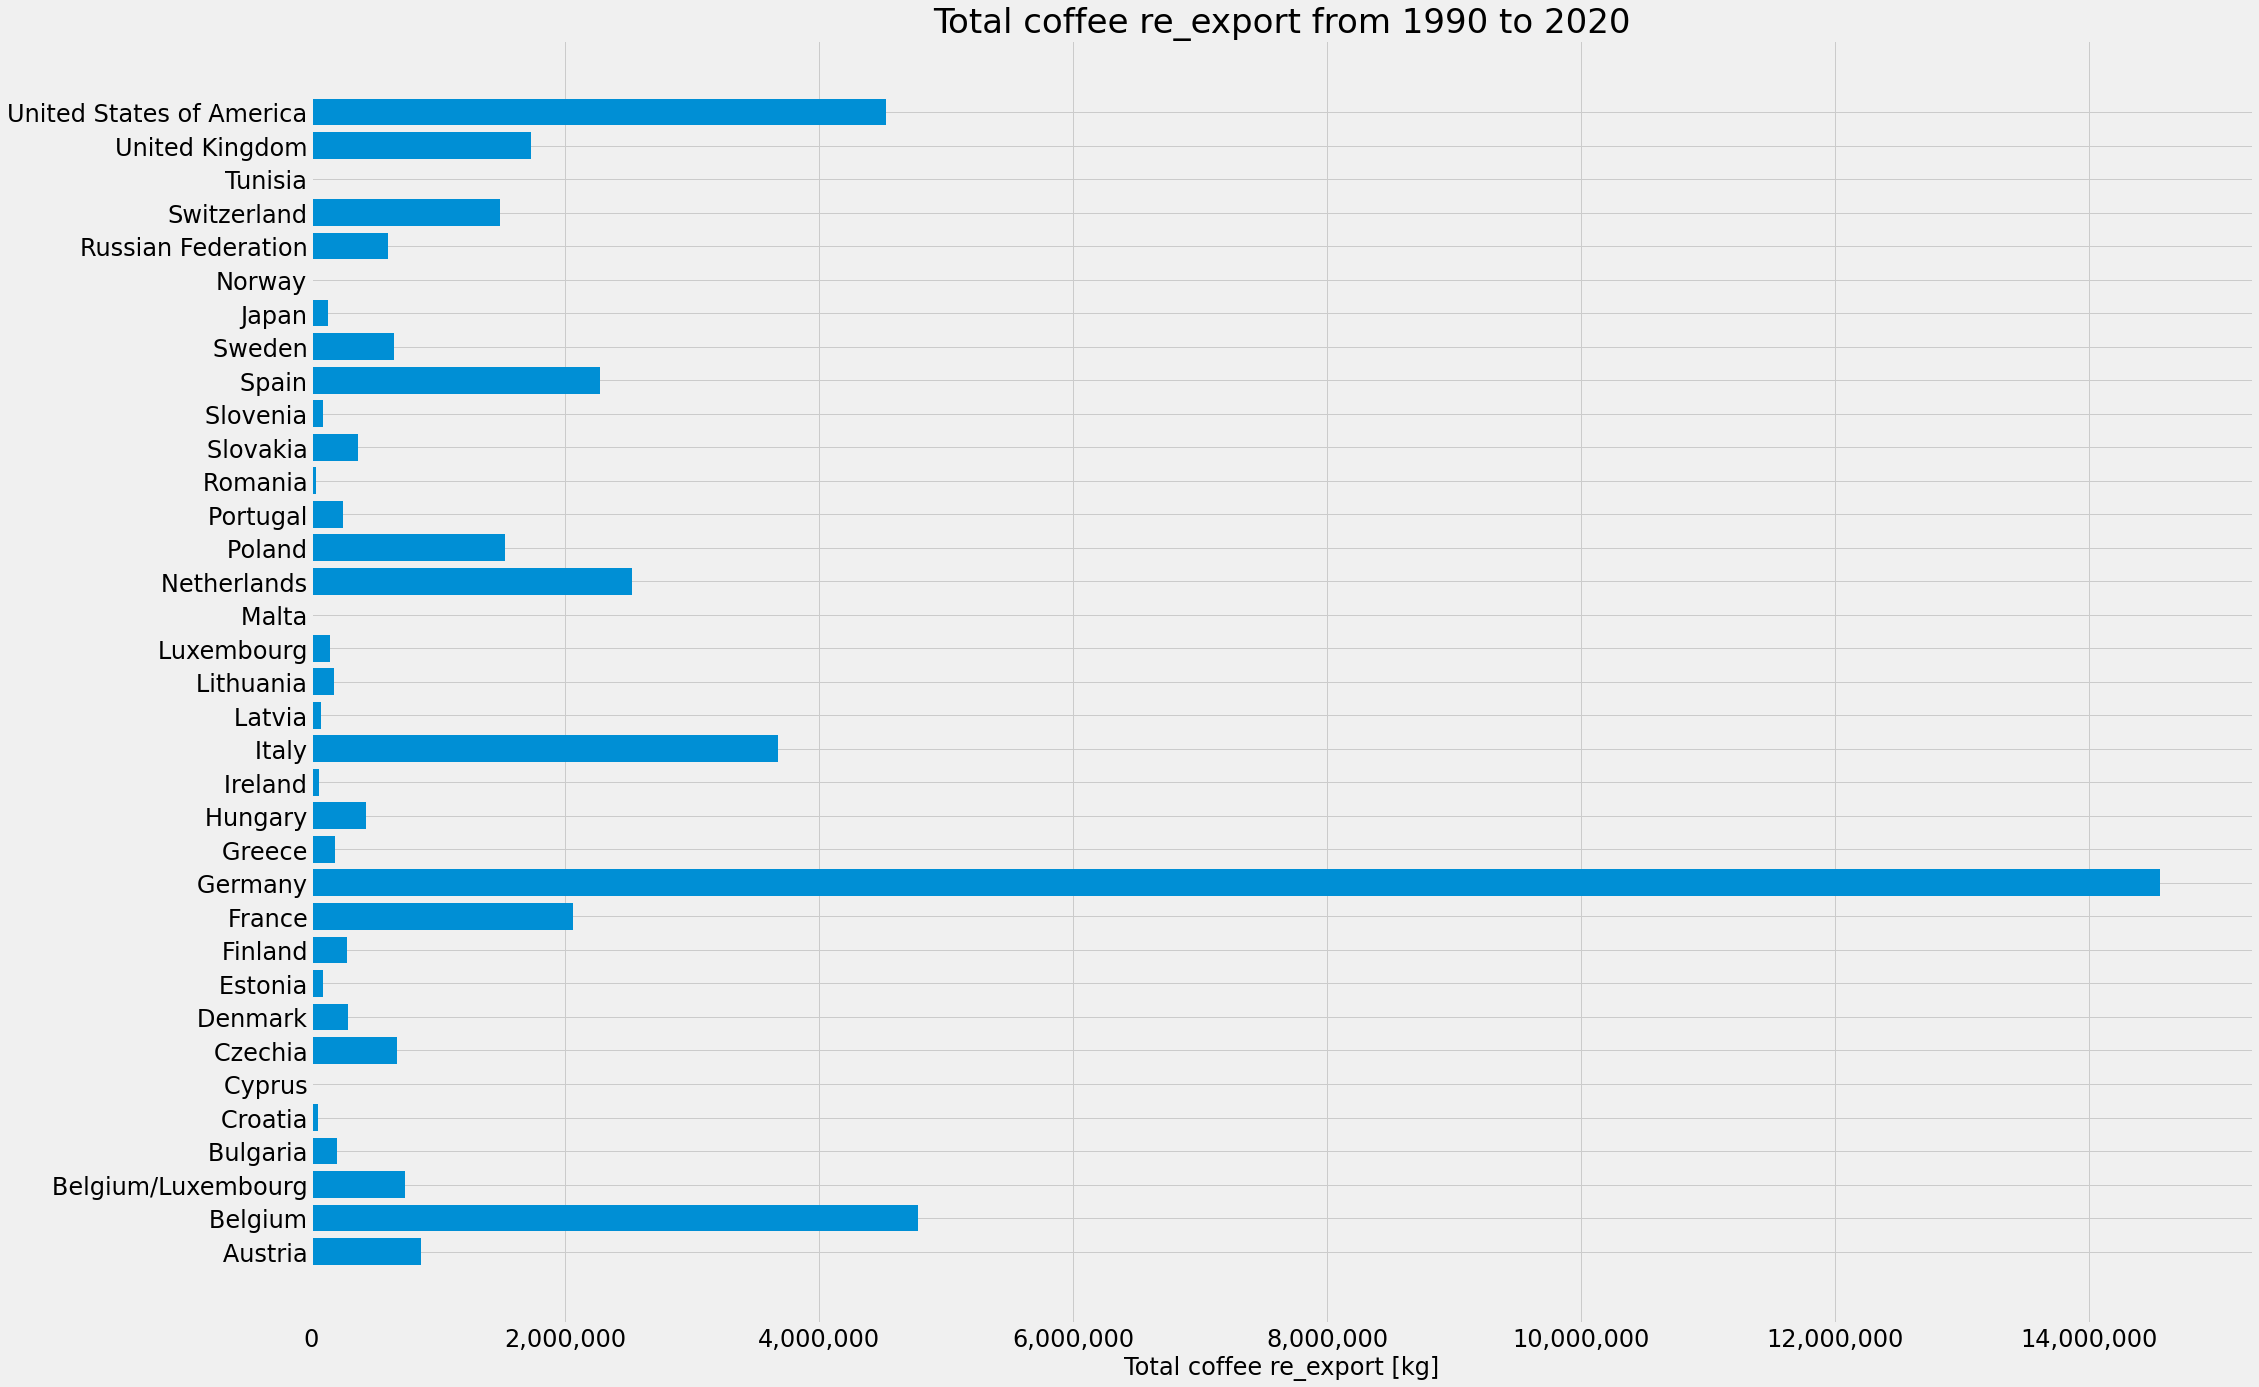

In [41]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(31, 22))

#Horizontal barchart
plt.barh(df_re_export["Country"], df_re_export["Total_re_export"])

# X-axis value size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Label title
plt.xlabel('Total coffee re_export [kg]', fontsize=24)

current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#Title label
plt.title("Total coffee re_export from 1990 to 2020", fontsize=34)

plt.show();